### Proceso de limpieza y preparación
#### Proyecto Captone

[Propósito](#propósito)

[Librerías](#librerías)

[Atípicos y Nulos](#tratamiento-de-datos-atípicos-y-nulos)

### Propósito

Este documento es un breve procedimiento que se realizar con el de obtener datos más informativos o más representativos a la población (hipotético), pues se realizará limpieza, eliminación de datos reelevantes y/o outliers de la información el cual nos facilite el proceso de análisis.

#### Librerías

In [229]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings("ignore")

In [230]:
stackOver_data = pd.read_csv('m1_survey_data.csv').replace('nan',None)

#### Valores duplicados

In [231]:
duplicated_data = stackOver_data[stackOver_data.duplicated()]

In [232]:
print('Total Duplicados: ',len(duplicated_data)) # Total duplicados

Total Duplicados:  154


In [233]:
stackOver_data.drop_duplicates(inplace=True)

In [234]:
respondet_duplicated = stackOver_data.loc[stackOver_data['Respondent'].duplicated(), 'Respondent']
print('Encuestados duplicados: ', len(respondet_duplicated))

Encuestados duplicados:  0


In [235]:
stackOver_data = stackOver_data.drop_duplicates(subset='Respondent', keep='last') #Se mantiene el último 
#en cuanto a ocurrencia, y se elimian los demás

In [236]:
missing_values = stackOver_data[stackOver_data.isnull().any(axis=1)]
print("Valores faltantes: ", len(missing_values))

Valores faltantes:  10390


### Tratamiento de datos atípicos y nulos

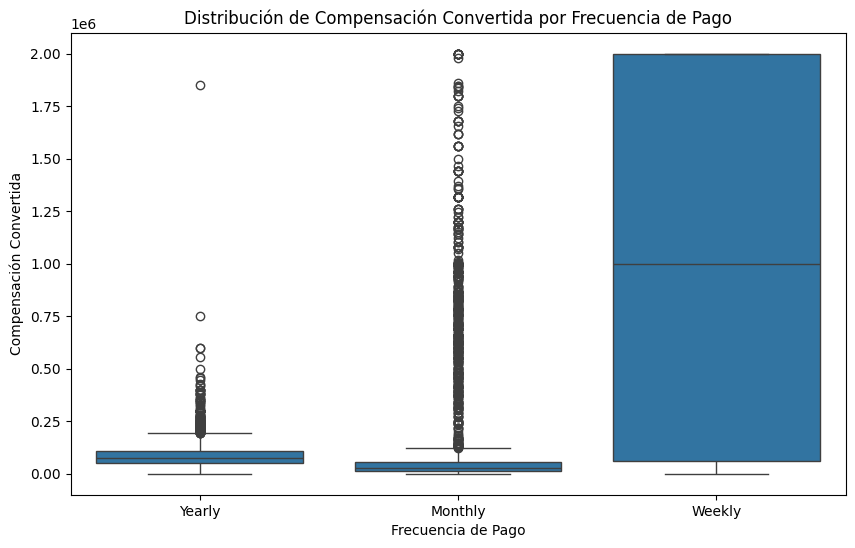

In [237]:
stackOver_data['ConvertedComp'] = pd.to_numeric(stackOver_data['ConvertedComp'], errors='coerce')

# Filtrar datos no nulos
filtered_data = stackOver_data.dropna(subset=['ConvertedComp', 'CompFreq'])

# Crear el diagrama de caja
plt.figure(figsize=(10, 6))
sns.boxplot(x='CompFreq', y='ConvertedComp', data=filtered_data)

# Añadir título y etiquetas
plt.title('Distribución de Compensación Convertida por Frecuencia de Pago')
plt.xlabel('Frecuencia de Pago')
plt.ylabel('Compensación Convertida')

# Mostrar el gráfico
plt.show()

In [238]:
stackOver_data['ConvertedComp'] = pd.to_numeric(stackOver_data['ConvertedComp'], errors='coerce')

# Filtrar datos no nulos
filtered_data = stackOver_data.dropna(subset=['ConvertedComp', 'CompFreq'])

# Crear una función para eliminar outliers basada en el IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Aplicar la función a cada grupo de 'CompFreq'
filtered_data = filtered_data.groupby('CompFreq').apply(lambda x: remove_outliers(x, 'ConvertedComp'))

# Resetear el índice para obtener un DataFrame limpio
filtered_data = filtered_data.reset_index(drop=True)

In [239]:
Q1 = filtered_data['Age'].quantile(0.25)
Q3 = filtered_data['Age'].quantile(0.75)

# Calcular el IQR
IQR = Q3 - Q1

# Determinar los límites para los valores atípicos
limite_inferior = Q1 - 1.3 * IQR
limite_superior = Q3 + 1.3 * IQR

# Filtrar los datos para eliminar los valores atípicos
stackOver_data_sin_outliers = filtered_data[(filtered_data['Age'] >= limite_inferior) & (filtered_data['Age'] <= limite_superior)]


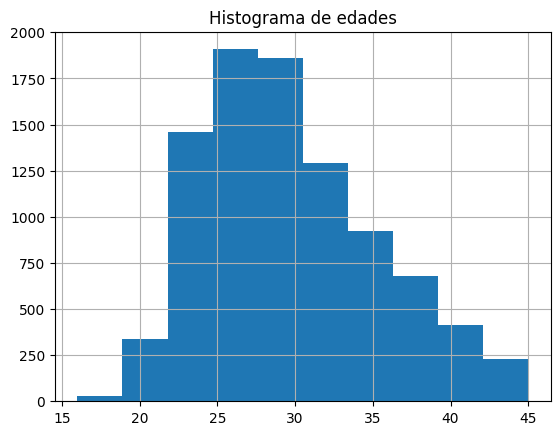

In [240]:
stackOver_data_sin_outliers['Age'].hist()
plt.title('Histograma de edades')
plt.show()

In [241]:
stackOver_data_sin_outliers['YearsCode'] = stackOver_data_sin_outliers['YearsCode'].replace('Less than 1 year',-1)
stackOver_data_sin_outliers['YearsCode'] = stackOver_data_sin_outliers['YearsCode'].astype('float')

In [242]:
stackOver_data_sin_outliers['YearsCodePro'] = stackOver_data_sin_outliers['YearsCodePro'].replace('Less than 1 year',-1)
stackOver_data_sin_outliers['YearsCodePro'] = stackOver_data_sin_outliers['YearsCodePro'].astype('float')

In [243]:
stackOver_data_sin_outliers['Age1stCode'] =stackOver_data_sin_outliers['Age1stCode'].replace('Younger than 5 years',-5)
stackOver_data_sin_outliers['Age1stCode'] = stackOver_data_sin_outliers['Age1stCode'].astype('float')

In [244]:
stackOver_data_sin_outliers['Age'] = stackOver_data_sin_outliers['Age'].replace('Less than 1 year',-1)
stackOver_data_sin_outliers['Age'] = stackOver_data_sin_outliers['Age'].astype('int')

In [245]:
categorical_cols = stackOver_data_sin_outliers.select_dtypes(include=['object', 'category'])
numerical_cols = stackOver_data_sin_outliers.select_dtypes(include=['number','int','float'])


Se decidió usar un proceso de imputación con KNN

In [247]:
# Codificar categorías a números
encoder = OrdinalEncoder()
categorical_cols_encoded = encoder.fit_transform(categorical_cols)

# Crear un imputer KNN para valores faltantes
imputer = KNNImputer(n_neighbors=3)

# Imputar valores faltantes
categorical_cols_imputed = imputer.fit_transform(categorical_cols_encoded)

# Convertir el resultado imputado a DataFrame
categorical_cols_imputed_df = pd.DataFrame(categorical_cols_imputed, columns=categorical_cols.columns)

# Decodificar números a categorías originales
categorical_cols_imputed_df = pd.DataFrame(
    encoder.inverse_transform(categorical_cols_imputed_df),
    columns=categorical_cols.columns
)


In [249]:
# Crear un imputer KNN para valores faltantes
imputer = KNNImputer(n_neighbors=10)

# Imputar valores faltantes
numerical_cols_imputed = imputer.fit_transform(numerical_cols)

# Convertir el resultado imputado a DataFrame
numerical_cols_imputed_df = pd.DataFrame(numerical_cols_imputed, columns=numerical_cols.columns)


In [256]:

# Asegurarse de que ambos DataFrames tengan el mismo índice
categorical_cols_imputed_df.index = numerical_cols_imputed_df.index

# Combinar los DataFrames
combined_df = categorical_cols_imputed_df.join(numerical_cols_imputed_df)


In [258]:
freq_to_annual = {
    'Yearly': 1,
    'Monthly': 12,
    'Weekly': 52
}

# Crear la función para normalizar la compensación total
def normalize_comp(row):
    freq = row['CompFreq']
    total_comp = row['CompTotal']
    annual_multiplier = freq_to_annual.get(freq, 1)  # Default to 1 if freq is not found
    return total_comp * annual_multiplier

# Crear la nueva columna 'CompAnual' aplicando la función
combined_df['CompAnual'] = combined_df.apply(normalize_comp, axis=1)


Como se realizó una equivalencia/normalización respecto a la variable que refleja el salario de los programadores a una columna general de salario anual, entonces se eliminará el resto de columnas

In [259]:
combined_df.drop(columns=['CompFreq','CompTotal'], inplace=True)

In [260]:
combined_df.to_csv('data_cleaned.csv')